In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle

import numpy as np

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])
import darkhistory.physics as dh_phys

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

## 21cmFAST

In [2]:
hplank = 6.62606896e-27 # erg s
NU_over_EV = (1.60217646e-12 / hplank)
NUIONIZATION = (13.60*NU_over_EV)  # ionization frequency of H
HeII_NUIONIZATION = (NUIONIZATION*4) # ionization frequency of HeII
HeI_NUIONIZATION = (24.59*NU_over_EV) # ionization frequency of HeI
TINY = 1e-30
PI = np.pi  # Pi constant

In [3]:
def HeI_ion_crosssec(nu):
    if nu < HeI_NUIONIZATION:
        return 0.0
    x = nu / NU_over_EV / 13.61 - 0.4434
    y = np.sqrt(x ** 2 + 2.136 ** 2)
    return 9.492e-16 * ((x - 1) ** 2 + 2.039 ** 2) * (y ** (0.5 * 3.188 - 5.5)) * ((1.0 + np.sqrt(y / 1.469)) ** -3.188)

def HeII_ion_crosssec(nu):
    Z = 2  # Atomic number for Helium
    if nu < HeII_NUIONIZATION:
        return 0.0
    if nu == HeII_NUIONIZATION:
        nu += TINY
    epsilon = np.sqrt(nu / HeII_NUIONIZATION - 1)
    return (6.3e-18) / Z ** 2 * (HeII_NUIONIZATION / nu) ** 4 * np.exp(4 - (4 * np.arctan(epsilon) / epsilon)) / (1 - np.exp(-2 * PI / epsilon))

def HI_ion_crosssec(nu):
    Z = 1  # Atomic number for Hydrogen
    
    if nu < NUIONIZATION:
        return 0.0
    if nu == NUIONIZATION:
        nu += TINY
    epsilon = np.sqrt(nu / NUIONIZATION - 1)
    return (6.3e-18) / Z ** 2 * (NUIONIZATION / nu) ** 4 * np.exp(4 - (4 * np.arctan(epsilon) / epsilon)) / (1 - np.exp(-2 * PI / epsilon))

## DH

In [5]:
def sigma_1e(E, Eth, Z): # cm^2(eV, eV)
    if E <= Eth:
        return 0
    eta = 1/np.sqrt(E/Eth - 1)
    return (2**9*np.pi**2*dh_phys.ele_rad**2)/(3*dh_phys.alpha**3*Z**2) * (Eth/E)**4 \
            * np.exp(-4*eta*np.arctan(1/eta)) / (1 - np.exp(-2*np.pi*eta))

def sigma_HeI(E): # cm^2(eV)
    if E < 50: # eV
        return 0
    expn = -3.30 if E > 250 else -2.65
    return -12*sigma_1e(E, 13.6, 1) + 5.1e-20 * (E/250)**expn # cm^2

def dh_HI_xsec(E):
    return sigma_1e(E, 13.6, 1)

def dh_HeII_xsec(E):
    return sigma_1e(E, 54.4, 2)

def dh_HeI_xsec(E):
    return sigma_HeI(E)

## Plot

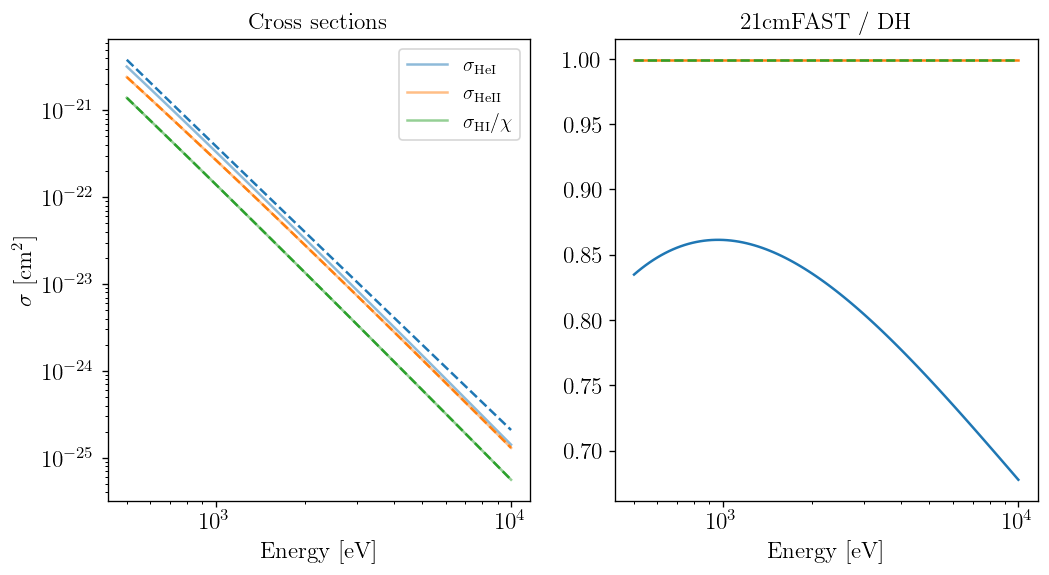

In [6]:
eng_arr = np.geomspace(500, 1e4, 100) # [eV]
nu_arr = eng_arr * NU_over_EV # [Hz]

HeI_ion_xsecs = np.array([HeI_ion_crosssec(nu) for nu in nu_arr])
HeII_ion_xsecs = np.array([HeII_ion_crosssec(nu) for nu in nu_arr])
HI_ion_xsecs = np.array([HI_ion_crosssec(nu) for nu in nu_arr])

dh_HeI_xsecs = np.array([dh_HeI_xsec(eng) for eng in eng_arr])
dh_HeII_xsecs = np.array([dh_HeII_xsec(eng) for eng in eng_arr])
dh_HI_xsecs = np.array([dh_HI_xsec(eng) for eng in eng_arr])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
ax.plot(eng_arr, HeI_ion_xsecs, color='C0', label=r'$\sigma_{\rm HeI}$', alpha=0.5)
ax.plot(eng_arr, HeII_ion_xsecs, color='C1', label=r'$\sigma_{\rm HeII}$', alpha=0.5)
ax.plot(eng_arr, HI_ion_xsecs/phys.chi, color='C2', label=r'$\sigma_{\rm HI}/\chi$', alpha=0.5)
ax.plot(eng_arr, dh_HeI_xsecs, color='C0', ls='--')
ax.plot(eng_arr, dh_HeII_xsecs, color='C1', ls='--')
ax.plot(eng_arr, dh_HI_xsecs/phys.chi, color='C2', ls='--')
ax.set(xscale='log', yscale='log')
ax.set(title='Cross sections', xlabel='Energy [eV]', ylabel=r'$\sigma$ [cm$^2$]')
ax.legend()

ax = axs[1]
ax.plot(eng_arr, HeI_ion_xsecs/dh_HeI_xsecs, color='C0', label='HI')
ax.plot(eng_arr, HeII_ion_xsecs/dh_HeII_xsecs, color='C1', label='HeII')
ax.plot(eng_arr, HI_ion_xsecs/dh_HI_xsecs, color='C2', label='HeI', ls='--')
ax.set(xscale='log')
ax.set(title='21cmFAST / DH', xlabel='Energy [eV]')

fig.savefig(f'plots/xc_xrayV21_xseccomp.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Photoionization cross section per nucleus (fixed)\n$(1-x)(f_\\mathrm{H}\\sigma_\\mathrm{HI}+f_\\mathrm{He}\\sigma_\\mathrm{HeI})+xf_\\mathrm{He}\\sigma_\\mathrm{HeII}$ [cm$^2$/A]')

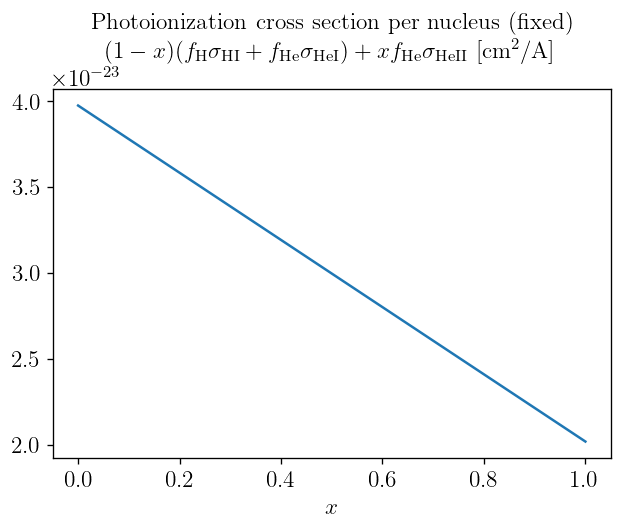

In [21]:
x_arr = np.linspace(0, 1, 100)

eng = 1e3 # [eV]

f_H = phys.n_H / phys.n_A
f_He = phys.n_He / phys.n_A

tot_xsec_arr = (dh_HI_xsec(eng) * f_H + dh_HeI_xsec(eng) * f_He) * (1 - x_arr) + dh_HeII_xsec(eng) * f_He * x_arr

plt.plot(x_arr, tot_xsec_arr)
plt.xlabel(r'$x$')
plt.title('Photoionization cross section per nucleus (fixed)\n'
          +r'$(1-x)(f_\mathrm{H}\sigma_\mathrm{HI}+f_\mathrm{He}\sigma_\mathrm{HeI})+xf_\mathrm{He}\sigma_\mathrm{HeII}$ [cm$^2$/A]')

In [ ]:
# /* function HeI_ion_crosssec returns the HI ionization cross section at parameter frequency
#  (taken from Verner et al (1996) */
# double HeI_ion_crosssec(double nu){
#     double x,y,Fy;

#     if (nu < HeI_NUIONIZATION)
#         return 0;

#     x = nu/NU_over_EV/13.61 - 0.4434;
#     y = sqrt(x*x + pow(2.136, 2));
#     return  9.492e-16*((x-1)*(x-1) + 2.039*2.039) *
#     pow(y, (0.5 * 3.188 - 5.5))
#     * pow(1.0 + sqrt(y/1.469), -3.188);
# }


# /* function HeII_ion_crosssec returns the HeII ionization cross section at parameter frequency
#  (taken from Osterbrock, pg. 14) */
# double HeII_ion_crosssec(double nu){
#     double epsilon, Z = 2;

#     if (nu < HeII_NUIONIZATION)
#         return 0;

#     if (nu == HeII_NUIONIZATION)
#         nu+=TINY;

#     epsilon = sqrt( nu/HeII_NUIONIZATION - 1);
#     return (6.3e-18)/Z/Z * pow(HeII_NUIONIZATION/nu, 4)
#     * pow(E, 4-(4*atan(epsilon)/epsilon)) / (1-pow(E, -2*PI/epsilon));
# }


# /* function HI_ion_crosssec returns the HI ionization cross section at parameter frequency
#  (taken from Osterbrock, pg. 14) */
# double HI_ion_crosssec(double nu){
#     double epsilon, Z = 1;

#     if (nu < NUIONIZATION)
#         return 0;

#     if (nu == NUIONIZATION)
#         nu+=TINY;

#     epsilon = sqrt( nu/NUIONIZATION - 1);
#     return (6.3e-18)/Z/Z * pow(NUIONIZATION/nu, 4)
#     * pow(E, 4-(4*atan(epsilon)/epsilon)) / (1-pow(E, -2*PI/epsilon));
# }

In [ ]:
# double integrand_in_nu_heat_integral(double nu, void * params){
#     double species_sum;
#     float x_e = *(double *) params;

#     // HI
#     species_sum = interp_fheat((nu - NUIONIZATION)/NU_over_EV, x_e)
#     * hplank*(nu - NUIONIZATION) * f_H * (1-x_e) * HI_ion_crosssec(nu);

#     // HeI
#     species_sum += interp_fheat((nu - HeI_NUIONIZATION)/NU_over_EV, x_e)
#     * hplank*(nu - HeI_NUIONIZATION) * f_He * (1-x_e) * HeI_ion_crosssec(nu);

#     // HeII
#     species_sum += interp_fheat((nu - HeII_NUIONIZATION)/NU_over_EV, x_e)
#     * hplank*(nu - HeII_NUIONIZATION) * f_He * x_e * HeII_ion_crosssec(nu);

#     return species_sum * pow(nu/((astro_params_hf->NU_X_THRESH)*NU_over_EV), -(astro_params_hf->X_RAY_SPEC_INDEX)-1);
# }
# double integrand_in_nu_ion_integral(double nu, void * params){
#     double species_sum, F_i;
#     float x_e = *(double *) params;

#     // photoionization of HI, prodicing e- of energy h*(nu - nu_HI)
#     F_i = interp_nion_HI((nu - NUIONIZATION)/NU_over_EV, x_e) +
#     interp_nion_HeI((nu - NUIONIZATION)/NU_over_EV, x_e) +
#     interp_nion_HeII((nu - NUIONIZATION)/NU_over_EV, x_e) + 1;
#     species_sum = F_i * f_H * (1-x_e) * HI_ion_crosssec(nu);

#     // photoionization of HeI, prodicing e- of energy h*(nu - nu_HeI)
#     F_i = interp_nion_HI((nu - HeI_NUIONIZATION)/NU_over_EV, x_e) +
#     interp_nion_HeI((nu - HeI_NUIONIZATION)/NU_over_EV, x_e) +
#     interp_nion_HeII((nu - HeI_NUIONIZATION)/NU_over_EV, x_e) + 1;
#     species_sum += F_i * f_He * (1-x_e) * HeI_ion_crosssec(nu);

#     // photoionization of HeII, prodicing e- of energy h*(nu - nu_HeII)
#     F_i = interp_nion_HI((nu - HeII_NUIONIZATION)/NU_over_EV, x_e) +
#     interp_nion_HeI((nu - HeII_NUIONIZATION)/NU_over_EV, x_e) +
#     interp_nion_HeII((nu - HeII_NUIONIZATION)/NU_over_EV, x_e) + 1;
#     species_sum += F_i * f_He * x_e * HeII_ion_crosssec(nu);

#     return species_sum * pow(nu/((astro_params_hf->NU_X_THRESH)*NU_over_EV), -(astro_params_hf->X_RAY_SPEC_INDEX)-1);
# }
# double integrand_in_nu_lya_integral(double nu, void * params){
#     double species_sum;
#     float x_e = *(double *) params;

#     // HI
#     species_sum = interp_n_Lya((nu - NUIONIZATION)/NU_over_EV, x_e)
#     * f_H * (double)(1-x_e) * HI_ion_crosssec(nu);

#     // HeI
#     species_sum += interp_n_Lya((nu - HeI_NUIONIZATION)/NU_over_EV, x_e)
#     * f_He * (double)(1-x_e) * HeI_ion_crosssec(nu);

#     // HeII
#     species_sum += interp_n_Lya((nu - HeII_NUIONIZATION)/NU_over_EV, x_e)
#     * f_He * (double)x_e * HeII_ion_crosssec(nu);

#     return species_sum * pow(nu/((astro_params_hf->NU_X_THRESH)*NU_over_EV), -(astro_params_hf->X_RAY_SPEC_INDEX)-1);

In [ ]:
from astropy import units as u
from astropy import constants as const

In [ ]:
E = 1000 # [eV]
print((E * u.eV / const.h).to(u.Hz).value)
print(1000 * NU_over_EV)

2.4179892420849184e+17
2.4179894137413264e+17


In [ ]:
Eth = 13.6 # [eV]
eta = 1/(np.sqrt(E/Eth - 1))
Z = 1
print(eta)
print((2**9*np.pi**2*dh_phys.ele_rad**2)/(3*dh_phys.alpha**3*Z**2) * (Eth/E)**4 * np.exp(-4*eta*np.arctan(1/eta)) / (1 - np.exp(-2*np.pi*eta)))

0.1174202288273835
1.1399357714009083e-23


In [ ]:
Z = 1
nu = 1000 * NU_over_EV # [Hz]
epsilon = np.sqrt(nu / NUIONIZATION - 1)
print(1/epsilon)
print((6.3e-18) / Z ** 2 * (NUIONIZATION / nu) ** 4 * np.exp(4 - (4 * np.arctan(epsilon) / epsilon)) / (1 - np.exp(-2 * PI / epsilon)))

0.11742022882738347
1.1391549800556292e-23
